[English version](index.ipynb)

In [ ]:
#| code-fold: true

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import preliz as pz
import pymc as pm
import xarray as xr

random_seed = sum(map(ord, "cooling"))


def compute_temperature(time, r, T_0, T_env):
    return T_env + (T_0 - T_env) * np.exp(-r * time)


def plot_estimated_curves(idata, x, y, T_env, color="C0", kind="mean", axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    else:
        fig = axes[0].figure

    t_grid = np.linspace(0, 9, num=100)
    t_grid_xr = xr.DataArray(t_grid, coords={"__idx__": list(range(100))}, dims="__idx__")

    mu_transformed = idata.posterior["alpha"] - idata.posterior["beta"] * t_grid_xr

    if kind == "outcome":
        coords = mu_transformed.coords
        dims = mu_transformed.dims
        draws = np.random.normal(
            loc=mu_transformed, scale=idata.posterior["sigma"].to_numpy()[..., np.newaxis]
        )

        mu_transformed = xr.DataArray(
            draws,
            coords=coords,
            dims=dims
        )

    mu_original = np.exp(mu_transformed) + T_env
    mu_transformed_mean = mu_transformed.mean(("chain", "draw")).to_numpy()
    mu_transformed_ci50 = mu_transformed.quantile((0.25, 0.75), ("chain", "draw")).to_numpy()
    mu_transformed_ci90 = mu_transformed.quantile((0.05, 0.95), ("chain", "draw")).to_numpy()

    mu_original_mean = mu_original.mean(("chain", "draw")).to_numpy()
    mu_original_ci50 = mu_original.quantile((0.25, 0.75), ("chain", "draw")).to_numpy()
    mu_original_ci90 = mu_original.quantile((0.05, 0.95), ("chain", "draw")).to_numpy()


    axes[0].plot(t_grid, mu_original_mean, color=color)
    axes[0].fill_between(
        x=t_grid, y1=mu_original_ci50[0], y2=mu_original_ci50[1], alpha=0.5, color=color
    )
    axes[0].fill_between(
        x=t_grid, y1=mu_original_ci90[0], y2=mu_original_ci90[1], alpha=0.5, color=color
    )

    axes[1].plot(t_grid, mu_transformed_mean, color=color)
    axes[1].fill_between(
        x=t_grid, y1=mu_transformed_ci50[0], y2=mu_transformed_ci50[1], alpha=0.5, color=color
    )
    axes[1].fill_between(
        x=t_grid, y1=mu_transformed_ci90[0], y2=mu_transformed_ci90[1], alpha=0.5, color=color
    )

    axes[0].scatter(x, y, color="0.33");
    axes[1].scatter(x, np.log(y - T_env), color="0.33");

    axes[0].set(xlabel="Tiempo (horas)", ylabel="Temperatura (°C)");
    axes[1].set(xlabel="Tiempo (horas)", ylabel="$\\log(T - T_\\text{ambiente})$");

    axes[0].grid(ls="--")
    axes[1].grid(ls="--")
    axes[0].set_axisbelow(True)
    axes[1].set_axisbelow(True)

    return fig, axes

## Introducción

Hace algunas semanas, mientras navegaba por internet, me encontré con [este posteo](https://x.com/nicorioscenteno/status/1621655101164118017) en la red social X. Allí, un productor agropecuario comentaba un experimento que estaba a punto de realizar para medir la capacidad de retener calor que ofrecían varios termos que tenía a su disposición.

![](imgs/posteo.png){width="500px"}

El experimento consistió en colocar agua a 80 °C en cada uno de los termos y registrar su temperatura a intervalos de tiempo determinados. Con los datos obtenidos, el experimentador podría concluir sobre cuál termo ofrecía la mejor (y la peor) capacidad de retener el calor.

Luego de varias mediciones, el autor del experimento [compartió](https://x.com/nicorioscenteno/status/1622039649622319104) los resultados obtenidos:

![](imgs/posteo2.png){width="500px"}

De ellos se desprende que el termo "nn tapa rosa" fue el de peor desempeño, ya que el agua en su interior perdió calor considerablemente más rápidamente que en cualquier otro.

Ahora bien, la pregunta inevitable es: ¿cuál es el termo que ofrece una mejor retención de calor?

Para responder a esta incógnita usaremos un modelo Bayesiano basado en al Ley de enfriamiento de Newton.

## Ley de enfriamiento de Newton

La **ley de enfriamiento de Newton** dice que la temperatura de un objeto cambia a una velocidad proporcional a la diferencia entre su temperatura y la del ambiente:

$$
\frac{dT(t)}{dt} = r \, (T_\text{ambiente} - T(t))
$$ {#eq-newton-cooling}

donde $r$ es una tasa de enfriamiento.

Una solución a la @eq-newton-cooling es:

$$
T(t) = T_\text{ambiente} + (T(0)- T_\text{ambiente}) \, e^{-rt}
$$ {#eq-newton-cooling-sol}

Esto significa que la temperatura presenta un decaimiento exponencial hacia la del ambiente conforme pasa el tiempo.

También se puede notar que el logaritmo de la diferencia entre la temperatura en un tiempo $t$ y la temperatura ambiente es una función lineal:

$$
\log\left(T(t) - T_\text{ambiente}\right) = \log\left(T(0) - T_\text{ambiente}\right) - rt
$$

que puede escribirse de manera más compacta como:

$$
\log\left(T(t) - T_\text{ambiente}\right) = \alpha - \beta t
$$

donde $\alpha = \log\left(T(0) - T_\text{ambiente}\right)$ y $\beta = r$.

La figura debajo muestra la forma que toma la @eq-newton-cooling-sol para diferentes tasas de enfriamiento $r$ junto a su correspondiente versión transformada.

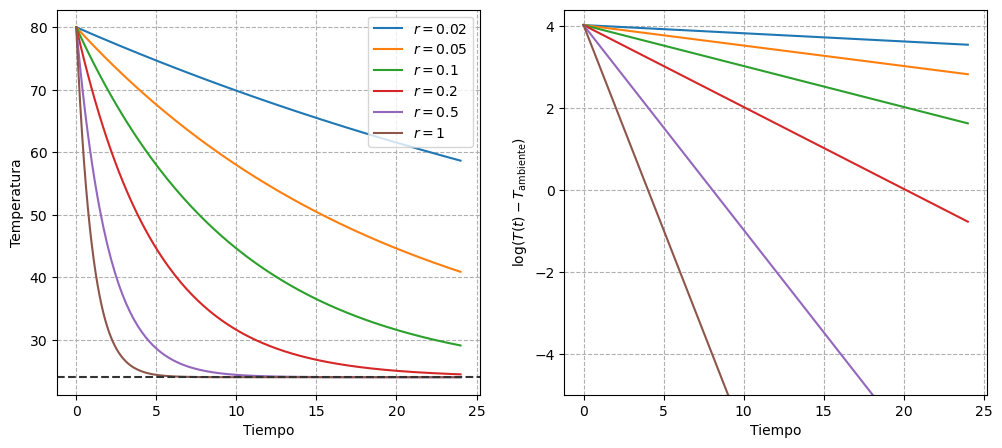

In [2]:
#| code-fold: true
#| label: fig-cooling
T_0, T_env = 80, 24
time_grid = np.linspace(0, 24, num=200)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for r in (0.02, 0.05, 0.1, 0.2, 0.5, 1):
    axes[0].plot(
        time_grid,
        compute_temperature(time=time_grid, r=r, T_0=T_0, T_env=T_env),
        label=f"$r={r}$"
    );
    axes[1].plot(
        time_grid,
        np.log(compute_temperature(time=time_grid, r=r, T_0=T_0, T_env=T_env) - T_env),
        label=f"$r={r}$"
    );

axes[0].axhline(y=T_env, color="0.2", lw=1.5, ls="--")
axes[0].grid(zorder=-99, ls="--")
axes[1].grid(zorder=-99, ls="--")
axes[1].set(ylim=(-5, 4.4))

axes[0].legend()
axes[0].set(xlabel="Tiempo", ylabel="Temperatura");
axes[1].set(xlabel="Tiempo", ylabel="$\\log(T(t) - T_\\text{ambiente})$");

Cuanto mayor sea el valor de $r$, peor será la capacidad del termo para retener temperatura. En otras palabras, el mejor termo será aquel con el valor de $r$ más bajo (asumiendo que $r > 0$).

## Elucidación de priors

En este artículo vamos a trabajar con modelos de la siguiente forma:

$$
\log(T(t_i) - T_\text{env}) \mid t_i \sim \text{Normal}(\alpha - \beta t_i, \sigma^2)
$$

Es decir, para un tiempo dado $t_i$, suponemos que el logaritmo de la diferencia entre la temperatura del agua y la temperatura ambiente sigue una distribución normal.


El parámetro de mayor interés es $\beta$, que representa la tasa de enfriamiento del agua en el termo. En primer lugar, sabemos que su valor debe ser positivo, ya que la temperatura del agua siempre desciende. Además, a partir de las curvas mostradas en la @fig-cooling, podemos suponer que un rango razonable para este parámetro se encuentra en el intervalo $(0, 1)$. Este rango implica que el agua del termo alcanzaría la temperatura ambiente, como mínimo, unas 5 horas después de haberlo llenado.

Usando [PreliZ](https://preliz.readthedocs.io/en/latest/) se puede obtener los parámetros de una distribución gamma que satisfagan nuestros requisitos.

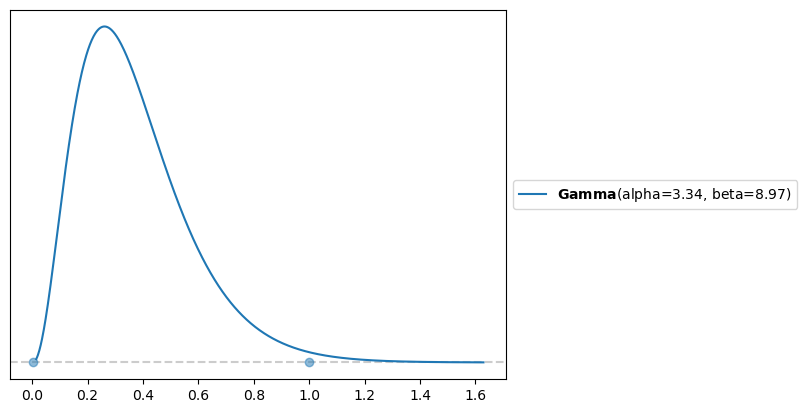

In [3]:
pz.maxent(pz.Gamma(), lower=0.001, upper=1, mass=0.99);

Otro parámetro desconocido en nuestro modelo es $\sigma$, el desvío estándar condicional.
Es importante destacar que este desvío no está expresado en grados centígrados, ya que describe la variabilidad de $\log(T(t_i) - T_\text{env})$, y no a la variablidad de $T(t_i)$.

Al observar el panel derecho de la @fig-cooling, se puede notar que el rango de variación de la respuesta cubre apenas unas pocas unidades. Por eso, en este caso voy a optar por una distribución gamma moderadamente informativa, que concentre una alta probabilidad en el intervalo $(0.05, 0.3)$.

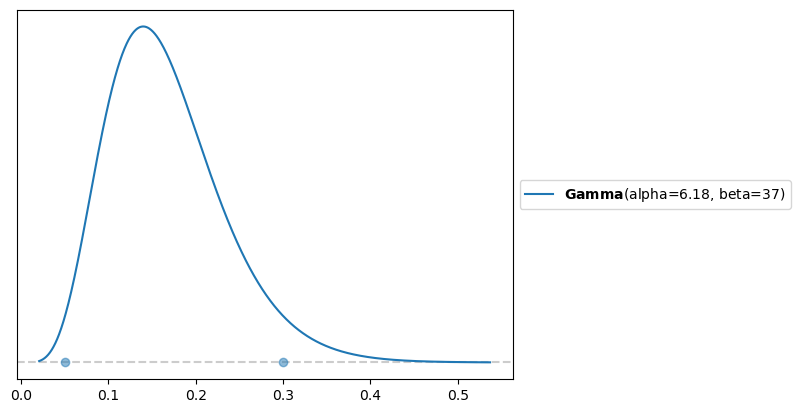

In [4]:
pz.maxent(pz.Gamma(), lower=0.05, upper=0.3, mass=0.95);

Finalmente, podríamos elucidar una distribución _a priori_ para $\alpha$. Sin embargo, no es un parámetro con una interpretación intuitiva.

Lo que sí podemos hacer es establecer un _prior_ para la temperatura inicial, que de manera implícita determine un _prior_ para $\alpha$.

Dado que en nuestro caso conocemos la temperatura del agua en $t = 0$, consideraremos dos enfoques:

* **Valor fijo** para $T(0)$: en este caso, $\alpha$ queda fijado a $\log(T(0) - T_\text{env})$.
* **Distribución informativa** para $T(0)$: centrada en el valor observado. Usamos una distribución normal con media $T(0)$ y desvío estándar de $0.3$ °C, lo que equivale a expresar que la temperatura inicial difiere, como máximo, en un grado de la temperatura medida.

## Datos

A partir de la foto compartida en el posteo de X, se pueden obtener las siguientes mediciones de temperatura:

In [5]:
T_env = 24
time = np.array([0, 180, 320, 500]) / 60 # en horas
data = {
    "stanley": np.array([80.0, 70.0, 65.0, 60.0]),
    "aluminio": np.array([80.0, 62.5, 57.5, 50.0]),
    "lumilagro": np.array([75.0, 65.0, 60.0, 55.0]),
    "nn-rosa": np.array([80.0, 47.5, 37.5, 30.0])
}

Cabe destacar que el valor de la temperatura ambiente (`T_env`) es un supuesto, ya que no aparece en ninguno de los posteos.

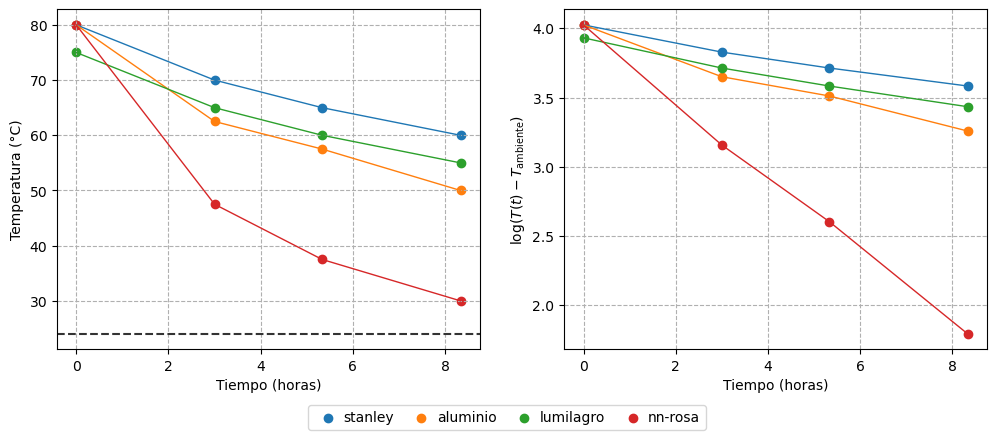

In [6]:
#| code-fold: true}
#| label: fig-data
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.subplots_adjust(bottom=0.2)

for i, (brand, temperatures) in enumerate(data.items()):
    axes[0].plot(time, temperatures, color=f"C{i}", lw=1)
    axes[1].plot(time, np.log(temperatures - T_env), color=f"C{i}", lw=1)
    axes[0].scatter(time, temperatures, color=f"C{i}", label=brand)
    axes[1].scatter(time, np.log(temperatures - T_env), color=f"C{i}", label=brand)

axes[0].set(xlabel="Tiempo (horas)", ylabel="Temperatura (°C)");
axes[1].set(xlabel="Tiempo (horas)", ylabel="$\\log(T(t) - T_\\text{ambiente})$");
axes[0].grid(ls="--")
axes[1].grid(ls="--")

axes[0].axhline(y=T_env, color="0.2", lw=1.5, ls="--")

axes[1].legend(
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, 0.025),
    bbox_transform=fig.transFigure,
    handletextpad=0.1,
    columnspacing=1
);

A simple vista, el termo Stanley mantiene las temperaturas más altas en todo momento, mientras que el de tapa rosa destaca por su pobre desempeño.
El Lumilagro, por su parte, muestra un rendimiento superior al de aluminio: aunque comenzó con una temperatura inicial más baja, su enfriamiento fue más lento.
Por último, no puede afirmarse con certeza si el Stanley supera realmente al Lumilagro, ya que, si bien sus mediciones fueron siempre más altas, también partió con una temperatura mayor.

Por otra parte, el panel derecho de @fig-data muestra una tendencia lineal para cada termo, lo que es consistente con el uso de un modelo lineal sobre $\log(T(t) - T_\text{env})$.

## Modelos

### Modelo 1: Termo Stanley con intercepto conocido

In [7]:
with pm.Model() as model_1:
    T_0 = pm.Data("T_0", 80)
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env))
    beta = pm.Gamma("beta", alpha=3.3, beta=9)
    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = pm.Deterministic("mu", alpha - beta * time)
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=np.log(data["stanley"] - T_env))


with model_1:
    idata_1 = pm.sample(random_seed=random_seed, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


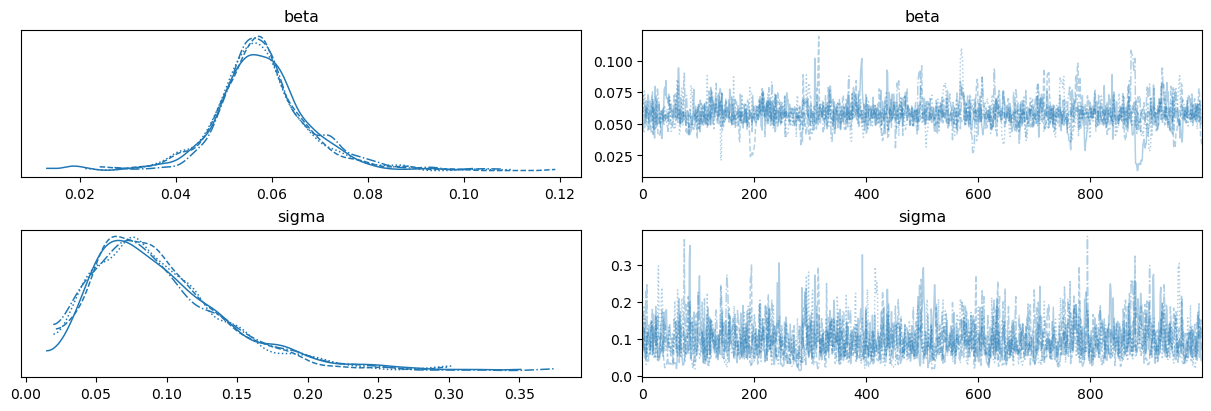

In [8]:
az.plot_trace(idata_1, var_names=["beta", "sigma"], backend_kwargs={"layout": "constrained"});

In [9]:
az.summary(idata_1, var_names=["beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.058,0.010,0.041,0.079,0.000,0.000,809.0,695.0,1.01
sigma,0.096,0.048,0.023,0.186,0.001,0.001,1190.0,942.0,1.00


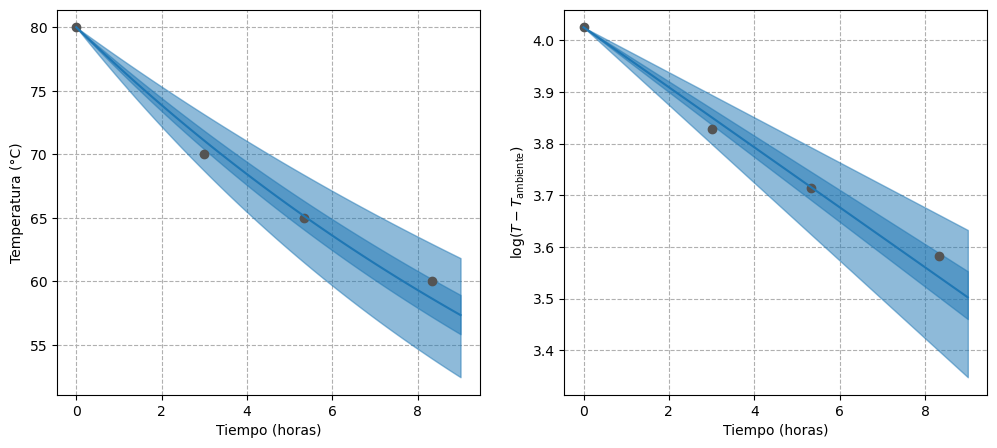

In [10]:
fig, axes = plot_estimated_curves(idata=idata_1, x=time, y=data["stanley"], T_env=T_env);

### Modelo 2: Termo Stanley con intercepto desconocido

In [11]:
with pm.Model() as model_2:
    T_0 = pm.Normal("T_0", mu=80, sigma=0.5)
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env))
    beta = pm.Gamma("beta", alpha=3.34, beta=12.8)
    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = pm.Deterministic("mu", alpha - beta * time)
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=np.log(data["stanley"] - T_env))


with model_2:
    idata_2 = pm.sample(random_seed=random_seed, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [T_0, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


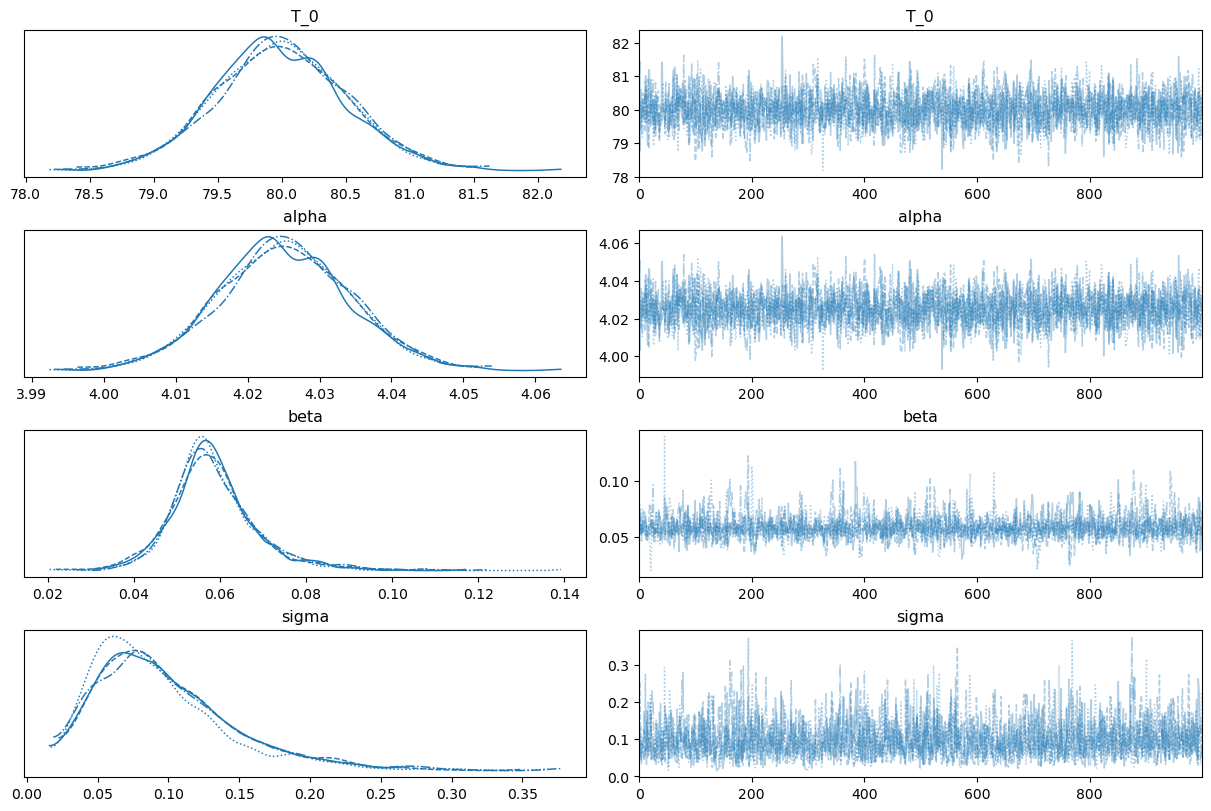

In [12]:
az.plot_trace(idata_2, var_names=["T_0", "alpha", "beta", "sigma"], backend_kwargs={"layout": "constrained"});

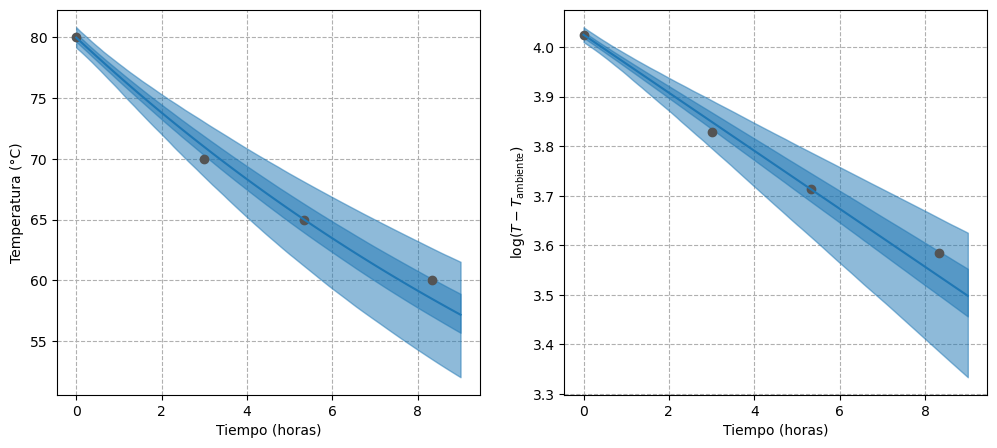

In [13]:
fig, axes = plot_estimated_curves(idata=idata_2, x=time, y=data["stanley"], T_env=T_env);

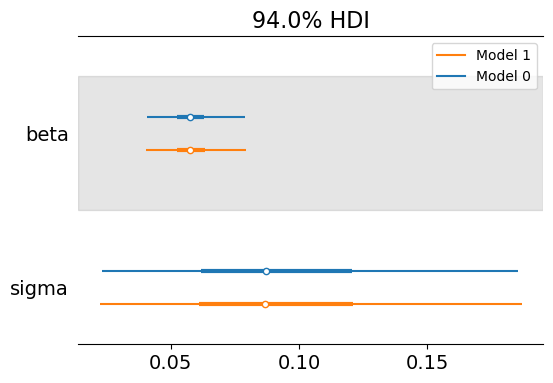

In [14]:
az.plot_forest([idata_1, idata_2], var_names=["beta", "sigma"], combined=True, figsize=(6, 4));

### Modelo 3: Todas las marcas + intercepto conocido

In [16]:
y = np.log(np.concatenate([temps for temps in data.values()]) - T_env)
brand_idx = np.repeat(np.arange(4), 4)
times = np.tile(time, 4)

coords = {
    "brand": list(data)
}
with pm.Model(coords=coords) as model_3:
    T_0 = pm.Data("T_0", [v.item(0) for v in data.values()], dims="brand")
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env), dims="brand")
    beta = pm.Gamma("beta", alpha=3.3, beta=12.8, dims="brand")
    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = pm.Deterministic("mu", alpha[brand_idx] - beta[brand_idx] * times)
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=y)

with model_3:
    idata_3 = pm.sample(random_seed=random_seed, target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


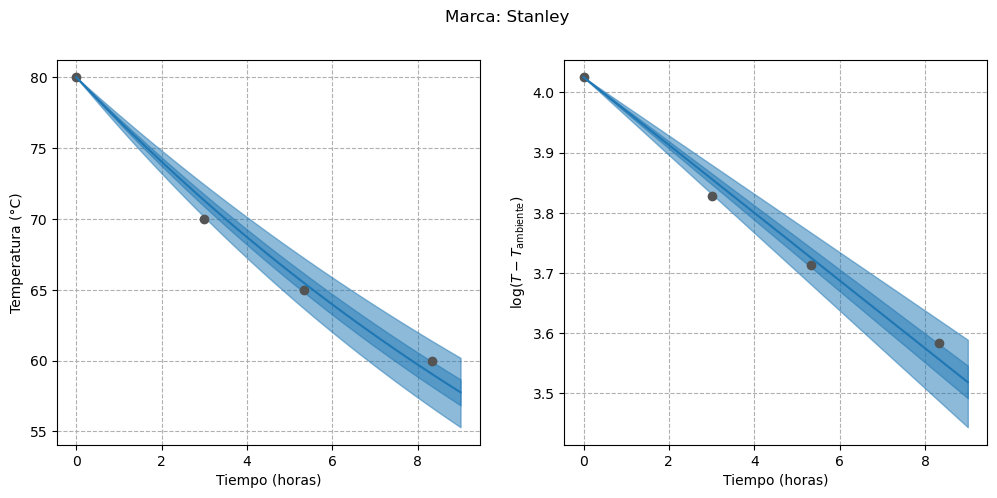

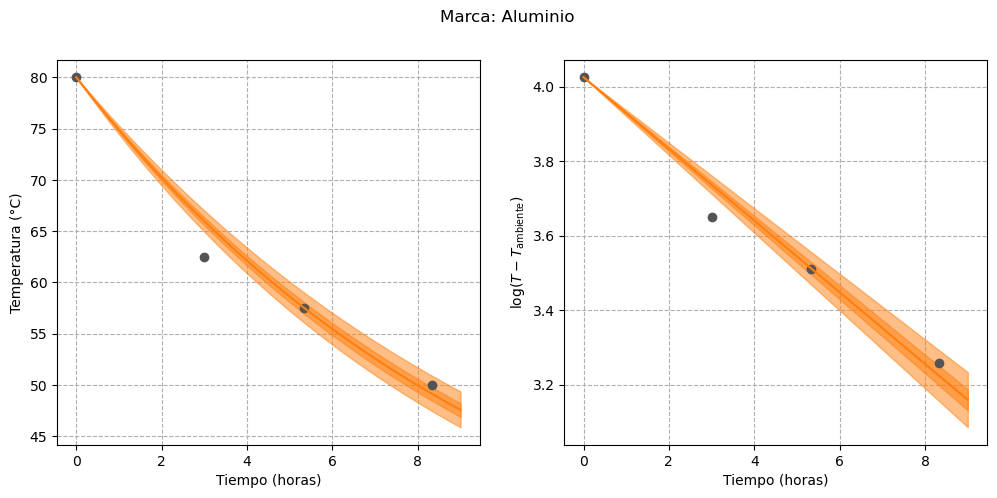

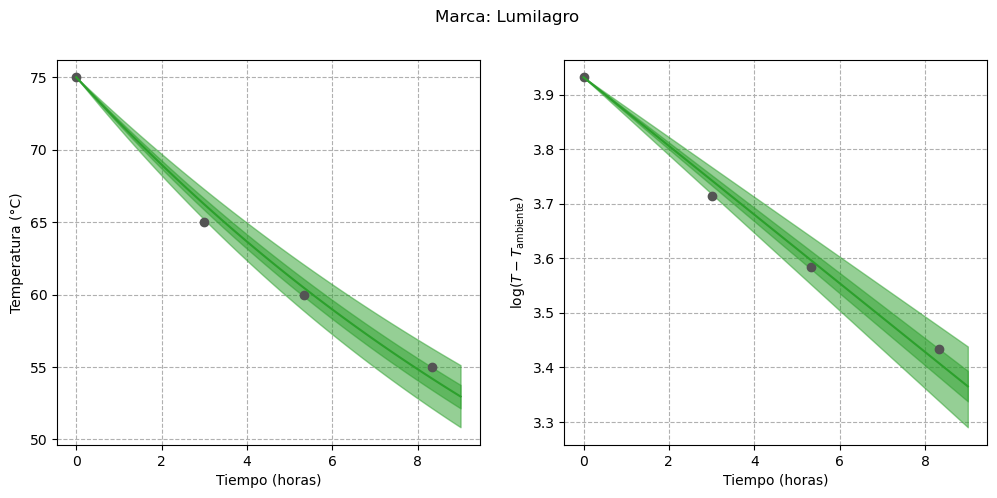

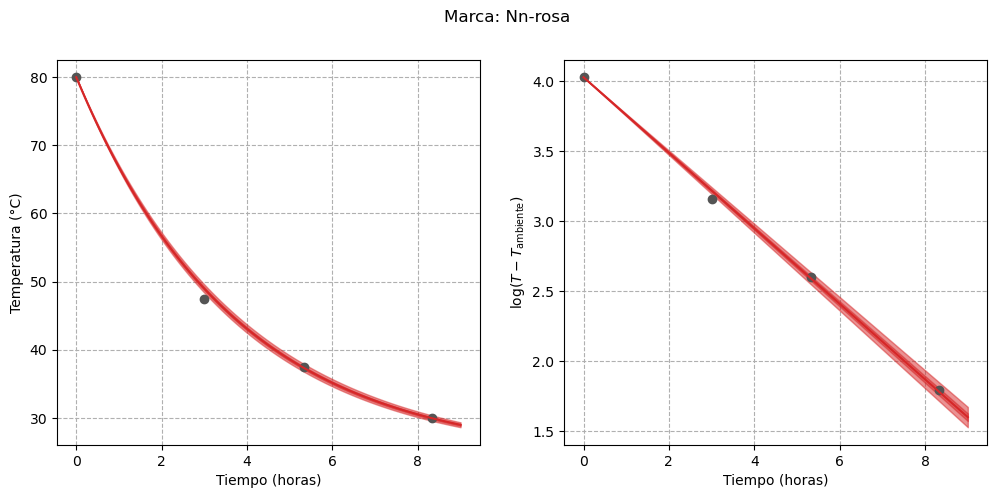

In [17]:
for i, brand in enumerate(data):
    fig, axes = plot_estimated_curves(
        idata=idata_3.sel(brand=brand),
        x=time,
        y=data[brand],
        T_env=T_env,
        color=f"C{i}",
    )
    fig.suptitle(f"Marca: {brand.capitalize()}")

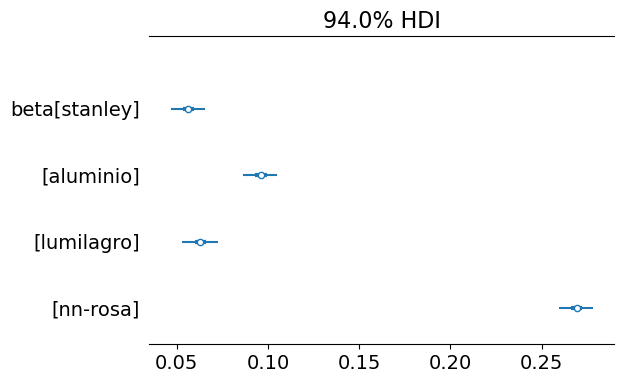

In [18]:
az.plot_forest(idata_3, var_names="beta", combined=True, figsize=(6, 4));

### Modelo 4: Todas las marcas + intercepto conocido + _partial pooling_ para $\beta$

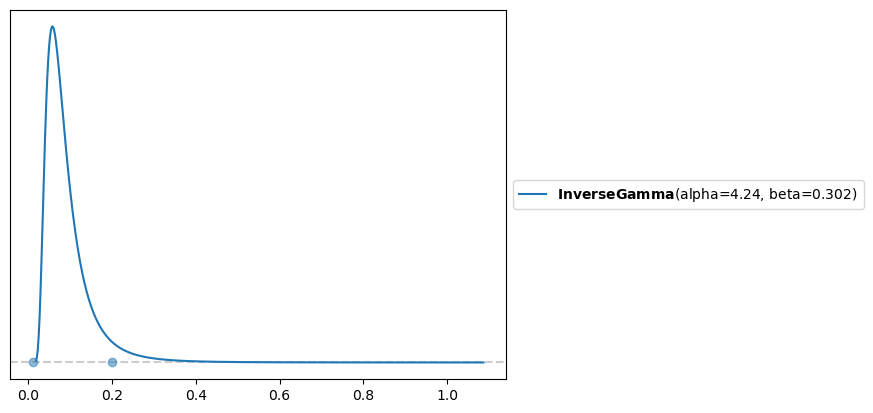

In [19]:
pz.maxent(pz.InverseGamma(), lower=0.01, upper=0.2, mass=0.95);

In [20]:
with pm.Model(coords=coords) as model_4:
    T_0 = pm.Data("T_0", [v.item(0) for v in data.values()], dims="brand")
    alpha = pm.Deterministic("alpha", np.log(T_0 - T_env), dims="brand")

    # Partial pooling
    beta_mu = pm.Normal("beta_mu", mu=3.3 / 12.8, sigma=0.075)
    beta_sigma = pm.InverseGamma("beta_sigma", alpha=4.2, beta=0.3)
    beta = pm.Gamma("beta", alpha=(beta_mu / beta_sigma)**2, beta=beta_mu / (beta_sigma**2), dims="brand")

    sigma = pm.Gamma("sigma", alpha=6.2, beta=37)
    mu = pm.Deterministic("mu", alpha[brand_idx] - beta[brand_idx] * times)
    pm.Normal("log(T - T_env)", mu=mu, sigma=sigma, observed=y)


with model_4:
    idata_4 = pm.sample_prior_predictive(draws=1000, random_seed=random_seed)
    idata_4.extend(pm.sample(random_seed=random_seed, target_accept=0.95))

Sampling: [beta, beta_mu, beta_sigma, log(T - T_env), sigma]
Initializing NUTS using jitter+adapt_diag...
/home/tomas/miniconda3/envs/pymc-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_mu, beta_sigma, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


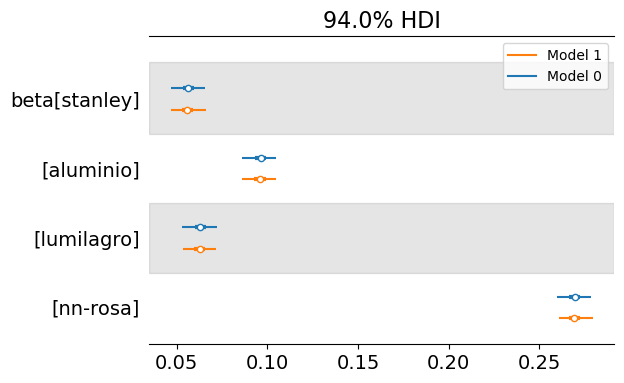

In [21]:
az.plot_forest([idata_3, idata_4], var_names="beta", combined=True, figsize=(6, 4));

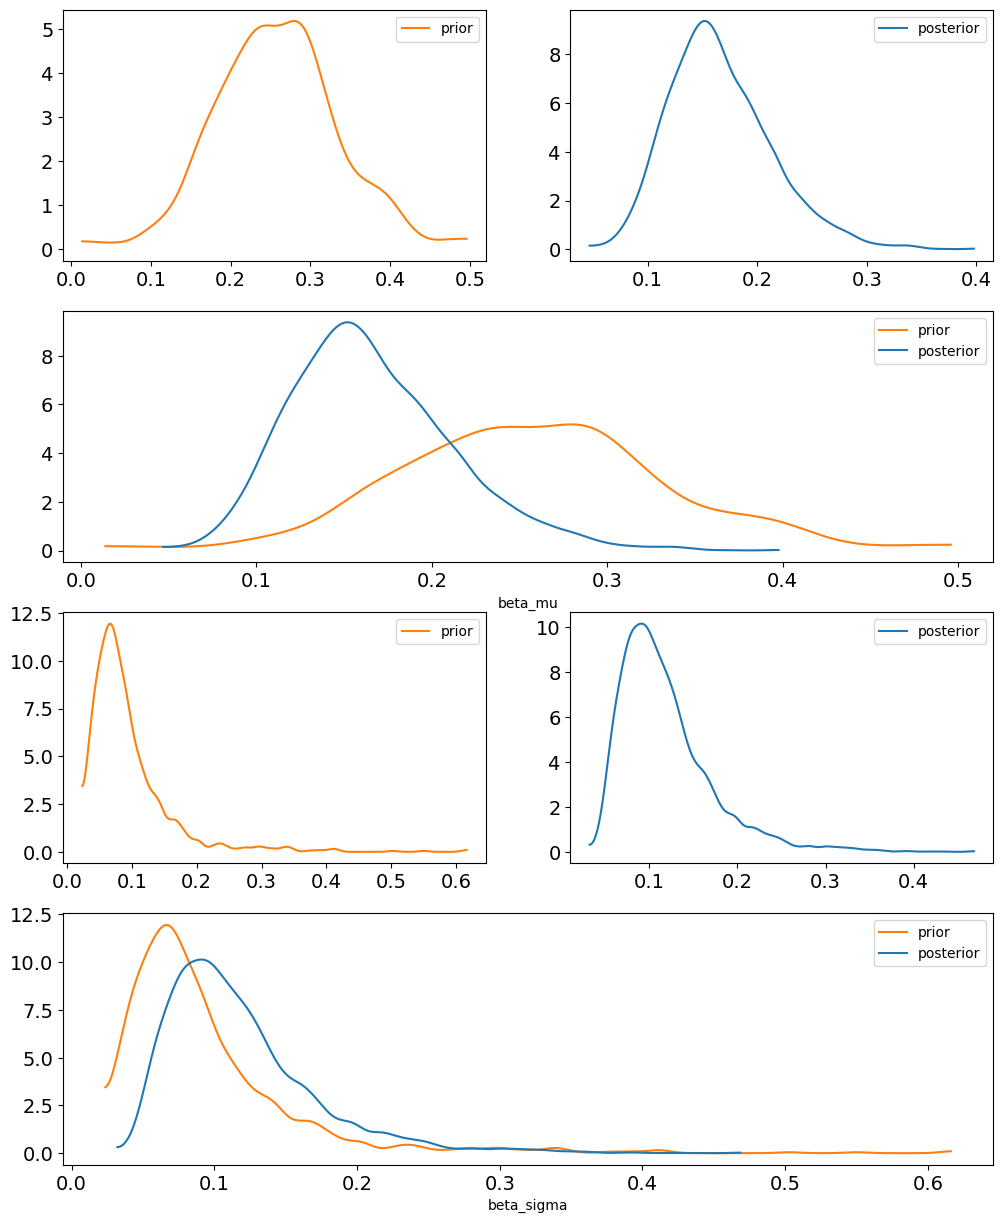

In [22]:
az.plot_dist_comparison(idata_4, var_names=["beta_mu", "beta_sigma"], figsize=(12, 15));

## ¿Cuál es el mejor termo?

In [23]:
beta_argmin = idata_4.posterior["beta"].argmin(axis=-1)
beta_argmax = idata_4.posterior["beta"].argmax(axis=-1)

p_min = [(beta_argmin == i).mean().item() for i in range(4)]
p_max = [(beta_argmax == i).mean().item() for i in range(4)]

print(p_min)
print(p_max)

[0.848, 0.00025, 0.15175, 0.0]
[0.0, 0.0, 0.0, 1.0]


## ¿Vale la pena incorporar información _a priori_?

In [25]:
coords = {"brand": list(data)}

with pm.Model(coords=coords) as model_5:
    alpha = pm.Flat("alpha", dims="brand")
    beta = pm.Flat("beta", dims="brand")
    sigma = pm.Uniform("sigma", lower=0, upper=100)
    mu = pm.Deterministic("mu", alpha[brand_idx] - beta[brand_idx] * times)
    pm.Normal("y", mu=mu, sigma=sigma, observed=y)

In [26]:
with model_5:
    idata_5 = pm.sample(random_seed=random_seed, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


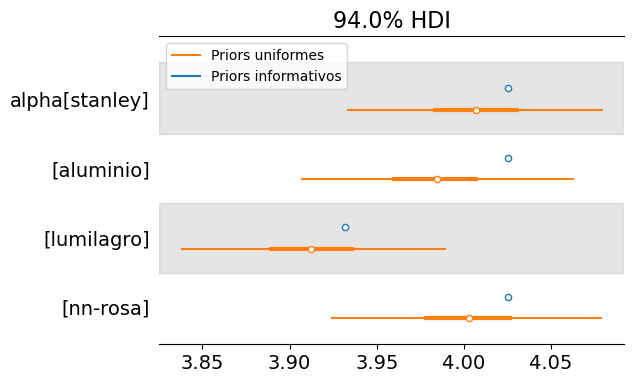

In [38]:
az.plot_forest(
    [idata_4, idata_5],
    model_names=["Priors informativos", "Priors uniformes"],
    var_names=["alpha"],
    combined=True,
    figsize=(6, 4)
);

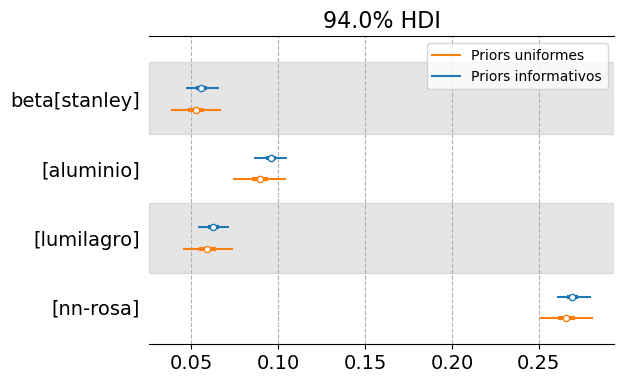

In [46]:
ax = az.plot_forest(
    [idata_4, idata_5],
    model_names=["Priors informativos", "Priors uniformes"],
    var_names=["beta"],
    combined=True,
    figsize=(6, 4)
)
ax[0].grid(axis="x", ls="--");

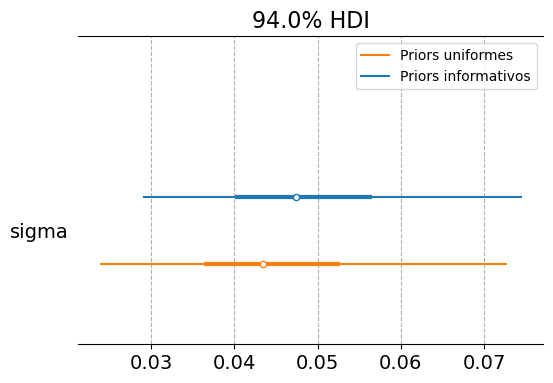

In [45]:
ax = az.plot_forest(
    [idata_4, idata_5],
    model_names=["Priors informativos", "Priors uniformes"],
    var_names=["sigma"],
    combined=True, figsize=(6, 4)
)
ax[0].grid(axis="x", ls="--");

In [30]:
beta_argmin = idata_5.posterior["beta"].argmin(axis=-1)
beta_argmax = idata_5.posterior["beta"].argmax(axis=-1)

p_min = [(beta_argmin == i).mean().item() for i in range(4)]
p_max = [(beta_argmax == i).mean().item() for i in range(4)]

print(p_min)
print(p_max)

[0.74575, 0.001, 0.25325, 0.0]
[0.0, 0.0, 0.0, 1.0]
